In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
plt.style.use('ggplot')
from keras import backend as K

Using Theano backend.


In [123]:
def read_data(file_path):
    column_names = ['user-id','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
    data = pd.read_csv(file_path,header = None, names = column_names)
    #print(data)
    return data

def feature_normalize(dataset):
    mu = np.mean(dataset,axis = 0)
    sigma = np.std(dataset,axis = 0)
    return (dataset - mu)/sigma
    
def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
def plot_activity(activity,data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, figsize = (15, 10), sharex = True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

In [89]:
dataset = read_data('/home/amit/Papers/Activity based recognition/DataSet/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt')
#print(dataset)

In [90]:
print("Normalising x")
dataset['x-axis'] = feature_normalize(dataset['x-axis'])
print("Normalising y")
dataset['y-axis'] = feature_normalize(dataset['y-axis'])
print("Normalising z")
dataset['z-axis'] = feature_normalize(dataset['z-axis'])

Normalising x
Normalising y
Normalising z


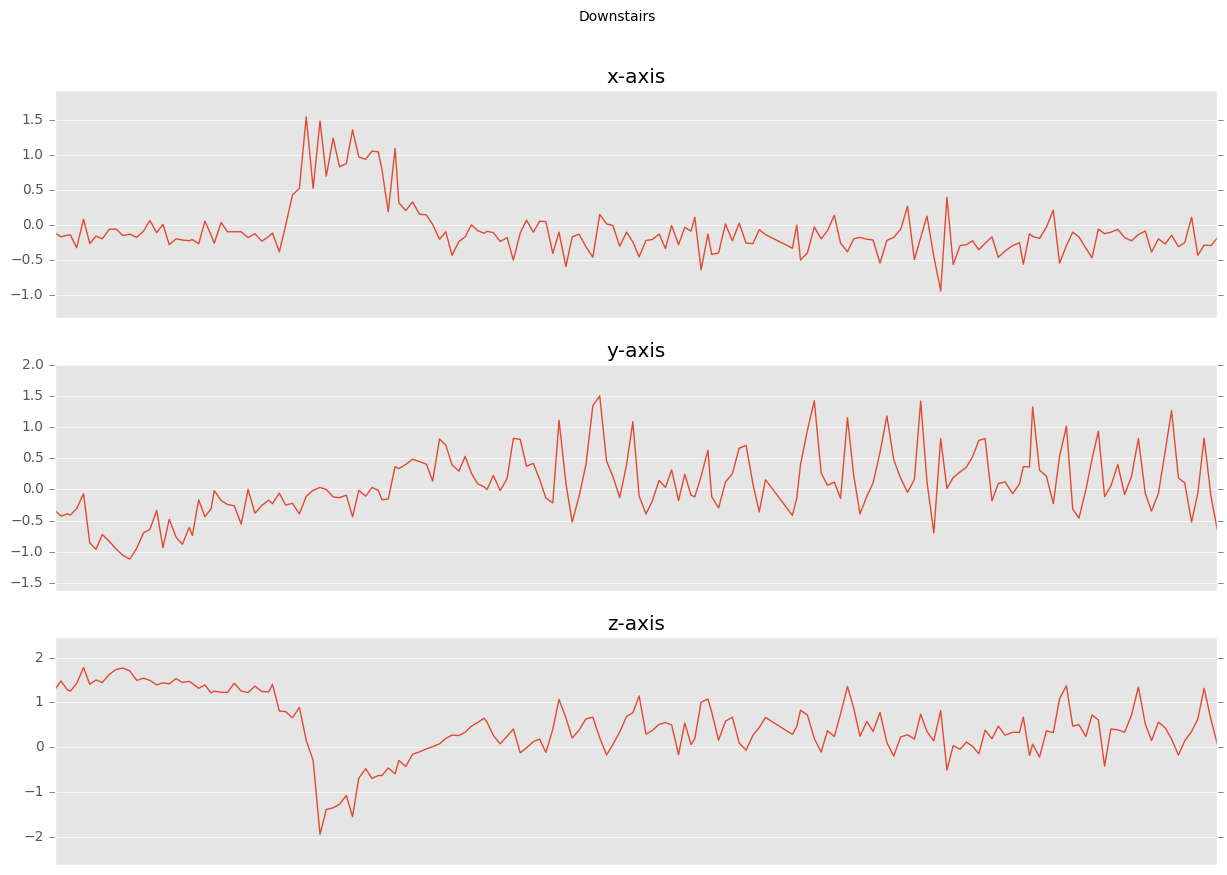

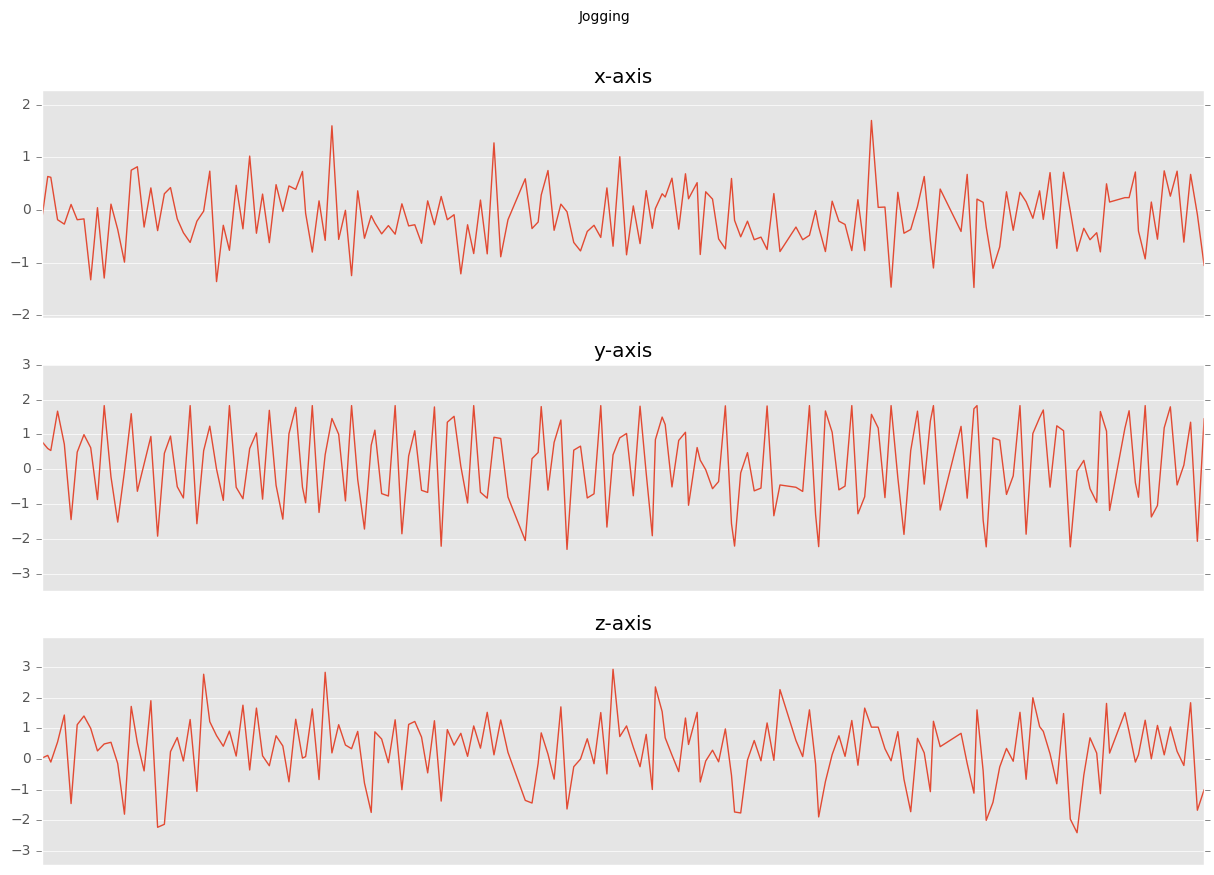

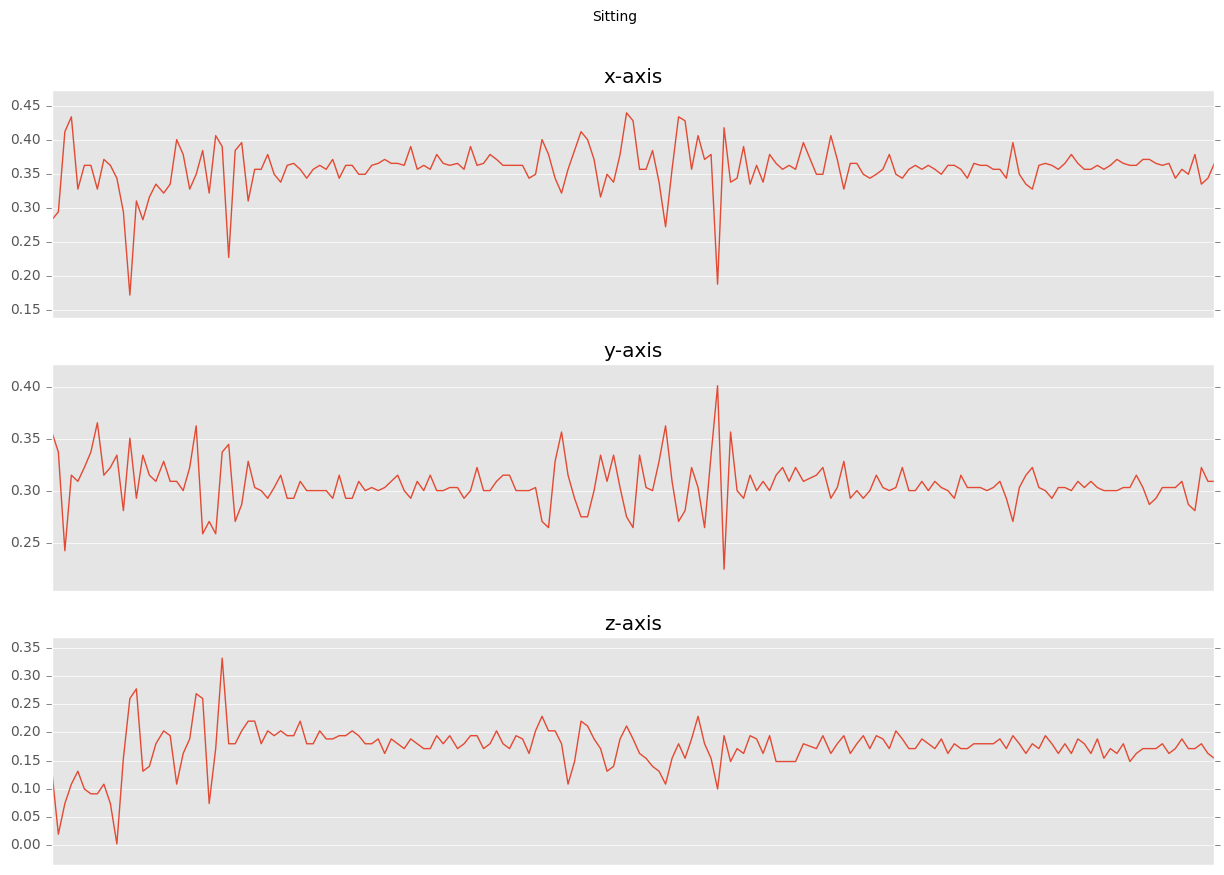

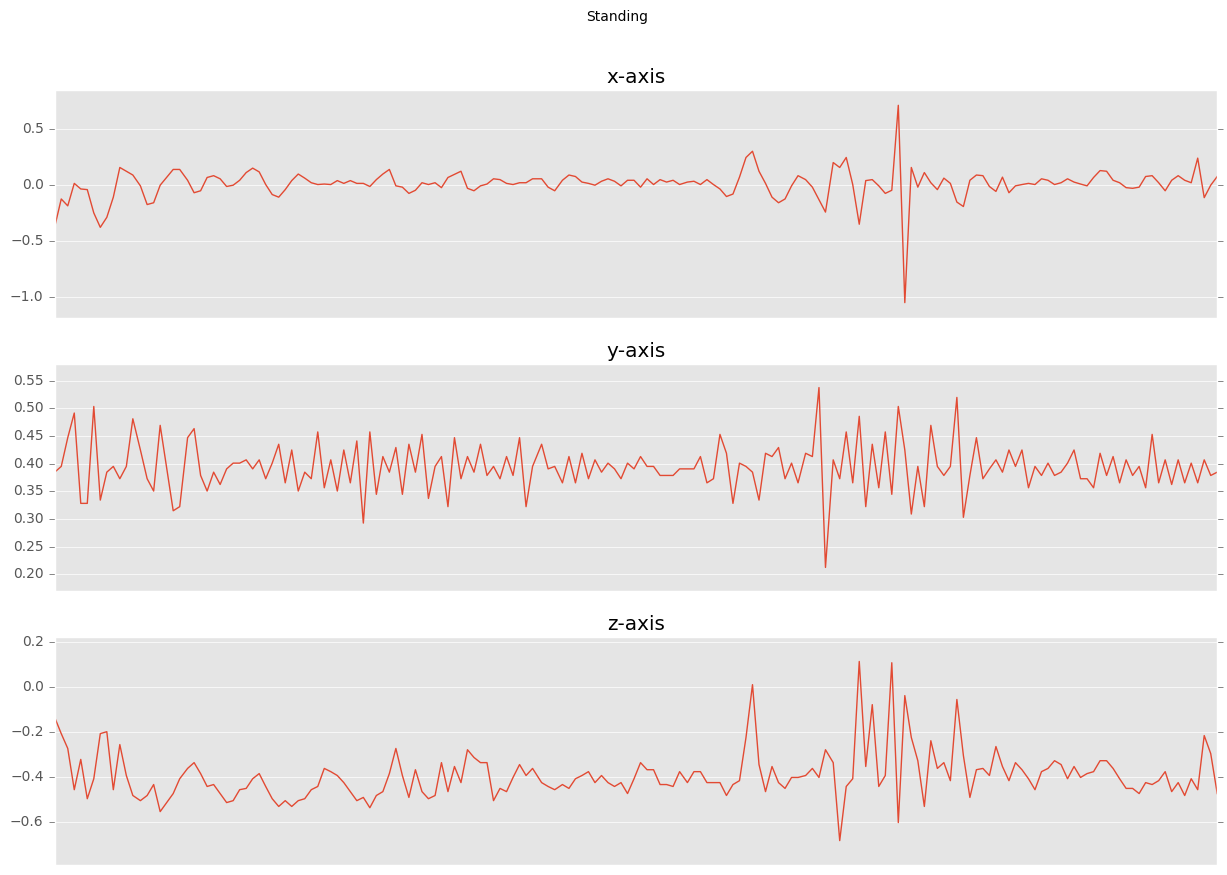

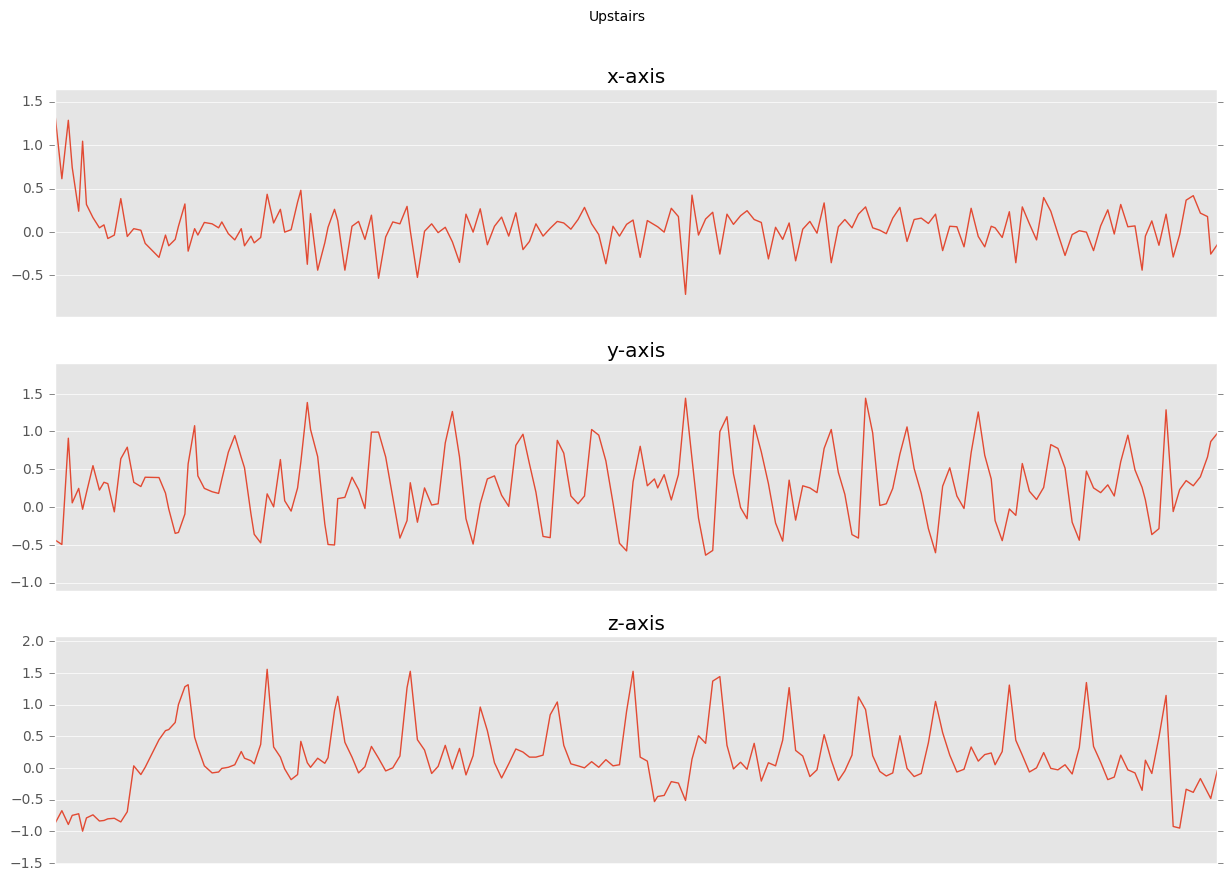

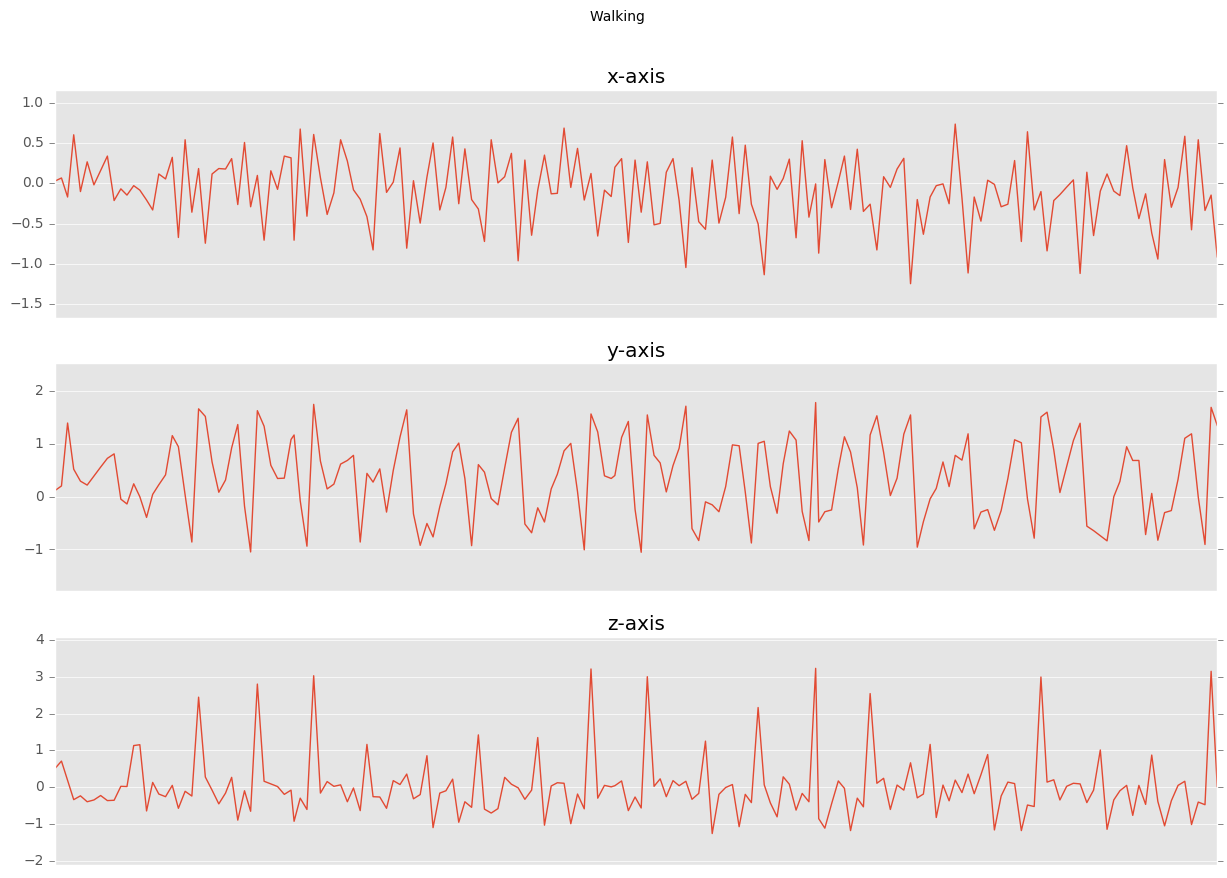

In [93]:
for activity in np.unique(dataset["activity"]):
    subset = dataset[dataset["activity"] == activity][:180]
    plot_activity(activity,subset)

In [96]:
def windows(data, size):
    start = 0
    while start < data.count():
        yield start, start + size
        start += int(size / 2)
        
def segment_signal(data,window_size = 90):
    segments = np.empty((0,window_size,3))
    #segments = np.empty((0,270))
    labels = np.empty((0))
    for (start, end) in windows(data["timestamp"], window_size):
        x = data["x-axis"][start:end]
        y = data["y-axis"][start:end]
        z = data["z-axis"][start:end]
        if(start%1000==0):
            print(start)
            #print(np.dstack([x,y,z]).ravel())
        if(len(dataset["timestamp"][start:end]) == window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
            labels = np.append(labels,stats.mode(data["activity"][start:end])[0][0])
    return segments, labels

In [97]:
segments, labels = segment_signal(dataset)

0


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:250: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


9000
18000
27000
36000
45000
54000
63000
72000
81000
90000
99000
108000
117000
126000
135000
144000
153000
162000
171000
180000
189000
198000
207000
216000
225000
234000
243000
252000
261000
270000
279000
288000
297000
306000
315000
324000
333000
342000
351000
360000
369000
378000
387000
396000
405000
414000
423000
432000
441000
450000
459000
468000
477000
486000
495000
504000
513000
522000
531000
540000
549000
558000
567000
576000
585000
594000
603000
612000
621000
630000
639000
648000
657000
666000
675000
684000
693000
702000
711000
720000
729000
738000
747000
756000
765000
774000
783000
792000
801000
810000
819000
828000
837000
846000
855000
864000
873000
882000
891000
900000
909000
918000
927000
936000
945000
954000
963000
972000
981000
990000
999000
1008000
1017000
1026000
1035000
1044000
1053000
1062000
1071000
1080000
1089000
1098000


In [101]:
print(segments.shape)
labels = np.asarray(pd.get_dummies(labels), dtype = np.int8)
import h5py
h5f = h5py.File('preprocessed_data_WSDM.h5', 'w')
h5f.create_dataset('data', data=segments)
h5f.create_dataset('output', data=labels)
h5f.close()

(24403, 90, 3)


In [2]:
import h5py
import numpy as np
from __future__ import print_function
h5f = h5py.File('preprocessed_data_WSDM.h5','r')
segments = h5f['data'][:]
labels= h5f['output'][:]
print(segments.shape, labels.shape)
h5f.close()

(24403, 90, 3) (24403, 6)


In [3]:
print(len(segments))
print(labels.shape)

# if K.image_dim_ordering() == 'th':
#     reshaped_segments = segments.reshape(len(segments), 1,90, 3)
#     input_shape = (1, 90, 3)
# else:
#     reshaped_segments = segments.reshape(len(segments),90, 3,1)
#     input_shape = (90, 3, 1)

reshaped_segments = segments.reshape(len(segments), 1,90, 3)

24403
(24403, 6)


In [4]:
train_test_split = np.random.rand(len(reshaped_segments)) < 0.70
print(train_test_split)

[ True False  True ...,  True  True False]


In [5]:
train_x = reshaped_segments[train_test_split]
train_y = labels[train_test_split]
test_x = reshaped_segments[~train_test_split]
test_y = labels[~train_test_split]
print(train_x.shape,train_y.shape)

(17035, 1, 90, 3) (17035, 6)


In [6]:
# from keras.datasets import mnist
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Activation, Flatten
# from keras.layers import Convolution1D, MaxPooling1D
# from keras.utils import np_utils
# from keras import backend as K

# batch_size = 128
# nb_classes = 6
# nb_epoch = 12

# # input image dimensions
# img_rows, img_cols = 90, 3
# # number of convolutional filters to use
# nb_filters = 32
# # size of pooling area for max pooling
# pool_size = (2, 2)
# # convolution kernel size
# kernel_size = (40, 3)



In [7]:
# model = Sequential()

# model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1],
#                         border_mode='valid',
#                         input_shape=input_shape))
# model.add(Activation('relu'))
# model.add(Flatten())
# model.add(Dense(128))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(nb_classes))
# model.add(Activation('softmax'))
# model.summary()
# model.compile(loss='categorical_crossentropy',
#               optimizer='adadelta',
#               metrics=['accuracy'])

# model.fit(train_x, train_y, batch_size=batch_size, nb_epoch=nb_epoch,
#           verbose=1, validation_data=(test_x, test_y))
# score = model.evaluate(test_x, test_y, verbose=0)
# print('Test score:', score[0])
# print('Test accuracy:', score[1])
# # batch_size = 512
# # nb_classes = 6
# # nb_epoch = 5

In [8]:
# model = Sequential()
# model.add(Dense(100, input_shape=(270,)))
# model.add(Activation('relu'))
# model.add(Dropout(0.2))
# model.add(Dense(nb_classes))
# model.add(Activation('softmax'))

# model.summary()

# model.compile(loss='categorical_crossentropy',
#               optimizer=RMSprop(),
#               metrics=['accuracy'])

# history = model.fit(train_x, train_y,
#                     batch_size=batch_size, nb_epoch=nb_epoch,
#                     verbose=1, validation_data=(test_x, test_y))
# score = model.evaluate(X_test, Y_test, verbose=0)
# print('Test score:', score[0])
# print('Test accuracy:', score[1])

In [9]:
input_height = 1
input_width = 90
num_labels = 6
num_channels = 3

batch_size = 10
kernel_size = 60
depth = 60
num_hidden = 1000

learning_rate = 0.0001
training_epochs = 5

total_batchs = train_x.shape[0] // batch_size

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.0, shape = shape)
    return tf.Variable(initial)
	
def depthwise_conv2d(x, W):
    return tf.nn.depthwise_conv2d(x,W, [1, 1, 1, 1], padding='VALID')
	
def apply_depthwise_conv(x,kernel_size,num_channels,depth):
    weights = weight_variable([1, kernel_size, num_channels, depth])
    biases = bias_variable([depth * num_channels])
    return tf.nn.relu(tf.add(depthwise_conv2d(x, weights),biases))
    
def apply_max_pool(x,kernel_size,stride_size):
    return tf.nn.max_pool(x, ksize=[1, 1, kernel_size, 1], 
                          strides=[1, 1, stride_size, 1], padding='VALID')

In [14]:
import tensorflow as tf


In [15]:
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])
print(type(X),X.get_shape())
c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
print(type(c),c.get_shape())
p = apply_max_pool(c,20,2)
print(type(p),p.get_shape())
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)
print(type(c),c.get_shape())

shape = c.get_shape().as_list()
print(shape)

c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])
print(c_flat.get_shape())

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

<class 'tensorflow.python.framework.ops.Tensor'> (?, 1, 90, 3)
<class 'tensorflow.python.framework.ops.Tensor'> (?, 1, 31, 180)
<class 'tensorflow.python.framework.ops.Tensor'> (?, 1, 6, 180)
<class 'tensorflow.python.framework.ops.Tensor'> (?, 1, 1, 1080)
[None, 1, 1, 1080]
(?, 1080)


In [16]:
loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [17]:
with tf.Session() as session:
    tf.initialize_all_variables().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batchs):    
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch:  0  Training Loss:  3.62702  Training Accuracy:  0.76607
Epoch:  1  Training Loss:  1.32235  Training Accuracy:  0.801937
Epoch:  2  Training Loss:  0.684357  Training Accuracy:  0.811153
Epoch:  3  Training Loss:  0.411888  Training Accuracy:  0.821896
Epoch:  4  Training Loss:  0.272925  Training Accuracy:  0.832756
Testing Accuracy: 0.821662
